# Barotropic tidal comparisons

Loads depth-frequency-time data and then plots integrated depth-band power for tidal comparisons.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import cmocean
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as pldates
import scipy.signal as sig
import numpy as np
for i in range(2):
    %matplotlib notebook

In [4]:
# import data

adcp = 'Slope'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2013
ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]

In [5]:
# extract plotting variables

t_stamp = int(ds[0].t_stamp)
start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                     # input end date in YYYY,MM,DD
depth = ds[0].depth.values
d = len(depth)

In [7]:
# select frequency band

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx      # returns index of nearest value

f_array = np.asarray(ds[0].specf_SN)    # input array to process 

f_name = 'Diurnal'          # Subdiurnal, Diurnal, Inertial, Semidiurnal, Continuum
if f_name == 'Diurnal':
    f_freq = 1.15e-5         # desired frequency constituent
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx 
elif f_name == 'Semidiurnal':
    f_freq = 2.24e-5
    f_idx = find_nearest(f_array, f_freq)
    up_f_idx = f_idx+1
    low_f_idx = f_idx
    
print("Desired frequency band:",f_name,'at', f_freq, "Hz")
print("---")
print("Index at upper freq cutoff:", up_f_idx)
print("Value at upper freq cutoff:", f_array[up_f_idx], "Hz" )
print('---')
print("Index at lower freq cutoff:", low_f_idx)
print("Value at lower freq cutoff:", f_array[low_f_idx], "Hz" )

f_band = f_array[low_f_idx:up_f_idx+1]              # remove unwanted frequencies
fup_stamp = f_band[-1]                              # freq stamps for use in output
flow_stamp = f_band[0]

print('---')
print("Length of new freq array: ", len(f_band))   # new freq interval
print(f'Upper limit at',fup_stamp,'Hz')            # freq upper limit
print(f'Lower limit at',flow_stamp,'Hz')           # freq lower limit

Desired frequency band: Diurnal at 1.15e-05 Hz
---
Index at upper freq cutoff: 6
Value at upper freq cutoff: 1.3020703125e-05 Hz
---
Index at lower freq cutoff: 5
Value at lower freq cutoff: 1.0850585937500001e-05 Hz
---
Length of new freq array:  2
Upper limit at 1.3020703125e-05 Hz
Lower limit at 1.0850585937500001e-05 Hz


## Depth-band PSD spectra

In [8]:
# integrate over band for each time step

u_power, v_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_SN)
    u_depth_power_temp,v_depth_power_temp = [],[]
    for j in range(d):
        u_time_power_temp,v_time_power_temp = [],[]
        for k in range(t):
            u_PSD_temp = ds[i].Sxxu_SN[j,low_f_idx:up_f_idx+1,k]
            u_power_temp = np.trapz(y=u_PSD_temp,x=f_band)
            u_time_power_temp.append(u_power_temp)
            v_PSD_temp = ds[i].Sxxv_SN[j,low_f_idx:up_f_idx+1,k]
            v_power_temp = np.trapz(y=v_PSD_temp,x=f_band)
            v_time_power_temp.append(v_power_temp)
        u_depth_power_temp.append(u_time_power_temp)
        v_depth_power_temp.append(v_time_power_temp)
    u_np = np.asarray(u_depth_power_temp)
    v_np = np.asarray(v_depth_power_temp)
    u_power.append(u_np)            # n_seg, [depth, time]
    v_power.append(v_np)            # n_seg, [depth, time]

In [9]:
# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(u_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        v_WKB_temp.append(v_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    u_WKB.append(u_WKB_temp)
    v_WKB.append(v_WKB_temp)

<IPython.core.display.Javascript object>


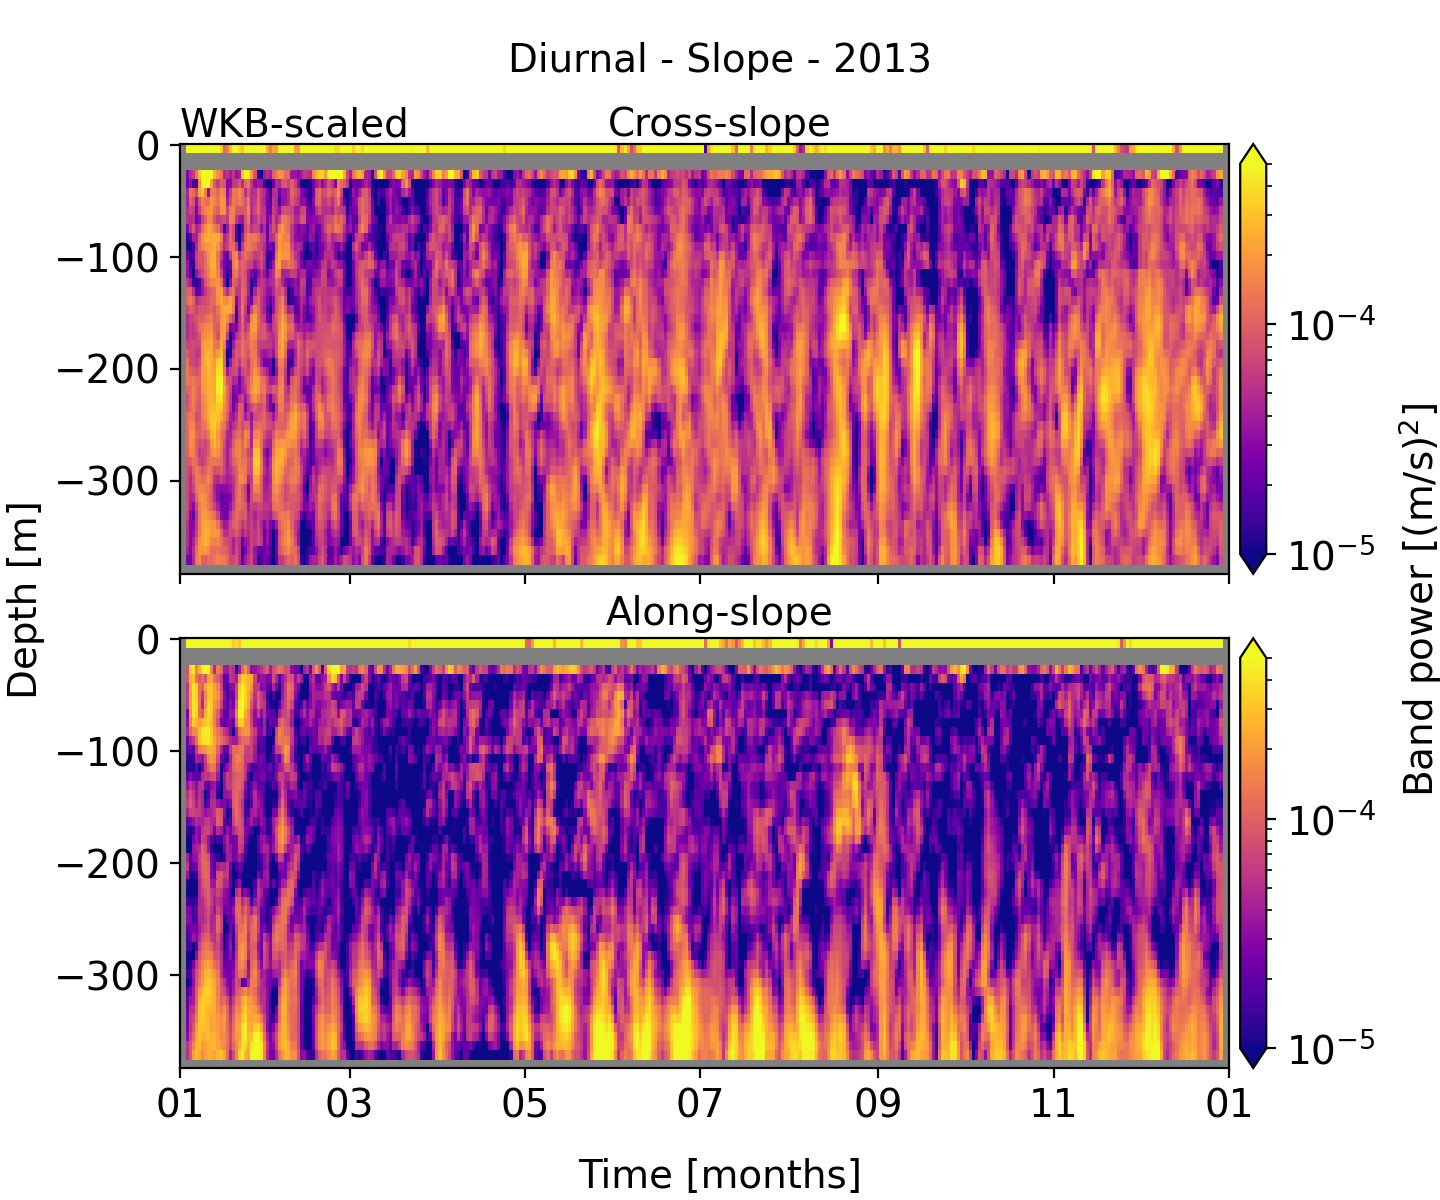

In [10]:
# plot PSD frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_SN, -depth, u_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_SN, -depth, v_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

#plt.savefig(fname=f'./plots/depthband_plots/{f_name}_psd_{adcp}_{t_stamp}.pdf',format='pdf')

## Barotropic comparison

In [11]:
# depth-average for each time step (run PSD process above, first)

if adcp == 'Slope':
    d_up = 8
elif adcp == 'Axis75':
    d_up = 45
elif adcp == 'Axis55':
    d_up = 34

u_PSD_avg, v_PSD_avg = [],[]
for i in range(n_seg):
    ds_temp_u = xr.DataArray(u_WKB[i][d_up:],dims=('depth','time'))
    ds_temp_v = xr.DataArray(v_WKB[i][d_up:],dims=('depth','time'))
    u_avg_temp = ds_temp_u.mean(dim='depth')
    v_avg_temp = ds_temp_v.mean(dim='depth')
    u_PSD_avg.append(u_avg_temp)
    v_PSD_avg.append(v_avg_temp)
    
# get magnitudes
U = []
for i in range(n_seg):
    U.append(np.hypot(u_PSD_avg[i],v_PSD_avg[i]))  

In [13]:
# divide into 4-month chunks

start_dates_dt64ns = np.array([f'{t_stamp}-01-01', f'{t_stamp}-05-01', f'{t_stamp}-09-01'], dtype='datetime64[ns]')
end_dates_dt64ns = np.array([f'{t_stamp}-05-01', f'{t_stamp}-09-01', f'{t_stamp+1}-01-01'], dtype='datetime64[ns]')
start_dates_dt64D = start_dates_dt64ns.astype('datetime64[D]')
end_dates_dt64D = end_dates_dt64ns.astype('datetime64[D]')
start_dates = start_dates_dt64ns.astype('float')
end_dates = end_dates_dt64ns.astype('float')

corrU = []
corrT = []
for i in range(len(start_dates)):
    corrUi = []
    corrTi = []
    for j in range(n_seg):
        corrUj = []
        corrTj = []
        for k in range(len(ds[j].spect_SN)):
            tk = ds[j].spect_SN[k].values
            tk = tk.astype('float')
            if tk >= start_dates[i] and tk <= end_dates[i]:
                corrUj.append(U[j][k])
                corrTj.append(tk)
        corrUi.append(corrUj)
        corrTi.append(corrTj)
    corrU.append(corrUi)
    corrT.append(corrTi)
    
# corrT[section][n_seg][time_step]

In [14]:
# get phase-lag correlation

step_t = 92700         # seconds between 'samples'
spring_neap = 1180310   # spring-neap period in seconds (13.661 days)
dst = xr.open_dataset(f'../Data/tide/tide_{f_name}_{t_stamp}.nc')
td_float = dst.time.astype('float')

phase_lag = []
xcorr_lag = []
for i in range(len(start_dates)):
    phase_lag_i = []
    xcorr_lag_i = []
    print(f'Interval {i}: {start_dates_dt64D[i]} to {end_dates_dt64D[i]}')
    for j in range(n_seg):
        if not corrT[i][j]:
            phase_lag_j = []
            phase_lag_i.append(phase_lag_j)
            xcorr_lag_j = []
            xcorr_lag_i.append(xcorr_lag_j)
            continue
        else:
            bt_float = corrT[i][j]                         # convert datetime64 to float (above) for interpolation and cross-correlation
            bt_amp = corrU[i][j]
            td_amp = np.interp(x=bt_float,xp=td_float.values,fp=dst.tide.values)     # interpolate to match lower resolution data time stamps

            # regularise data

            #bt_amp -= np.nanmean(bt_amp)
            #bt_amp /= np.nanstd(bt_amp)
            #td_amp -= np.nanmean(td_amp)
            #td_amp /= np.nanstd(td_amp)

            # get cross-correlation phase lag

            xcorr = sig.correlate(bt_amp, td_amp)
            xcorr_lag_i.append(xcorr)

            nsamples = len(bt_amp)           # length of time series in steps
            tmax = nsamples*step_t           # length of time series in seconds
            t = np.linspace(0.0, tmax, nsamples, endpoint=False)
            delta_t = np.linspace(-t[-1], t[-1], 2*nsamples-1)

            recovered_time_shift = delta_t[xcorr.argmax()]     # peak of xcorr gives phase lag
            recovered_phase_shift = 2*np.pi*(((0.5 + (recovered_time_shift/spring_neap)) % 1.0) - 0.5) / np.pi
            relative_phase_shift = (recovered_phase_shift*np.pi) / (2*np.pi)
            relative_time_shift = relative_phase_shift * 13.661
            print(f"Phase shift {j}: %.2f pi, or %.2f spring-neap periods." % (recovered_phase_shift, relative_phase_shift))
            phase_lag_i.append(relative_time_shift)
            
    phase_lag.append(phase_lag_i)
    xcorr_lag.append(xcorr_lag_i)

Interval 0: 2013-01-01 to 2013-05-01
Phase shift 0: 0.16 pi, or 0.08 spring-neap periods.
Interval 1: 2013-05-01 to 2013-09-01
Phase shift 0: 0.16 pi, or 0.08 spring-neap periods.
Interval 2: 2013-09-01 to 2014-01-01
Phase shift 0: 0.16 pi, or 0.08 spring-neap periods.


<IPython.core.display.Javascript object>


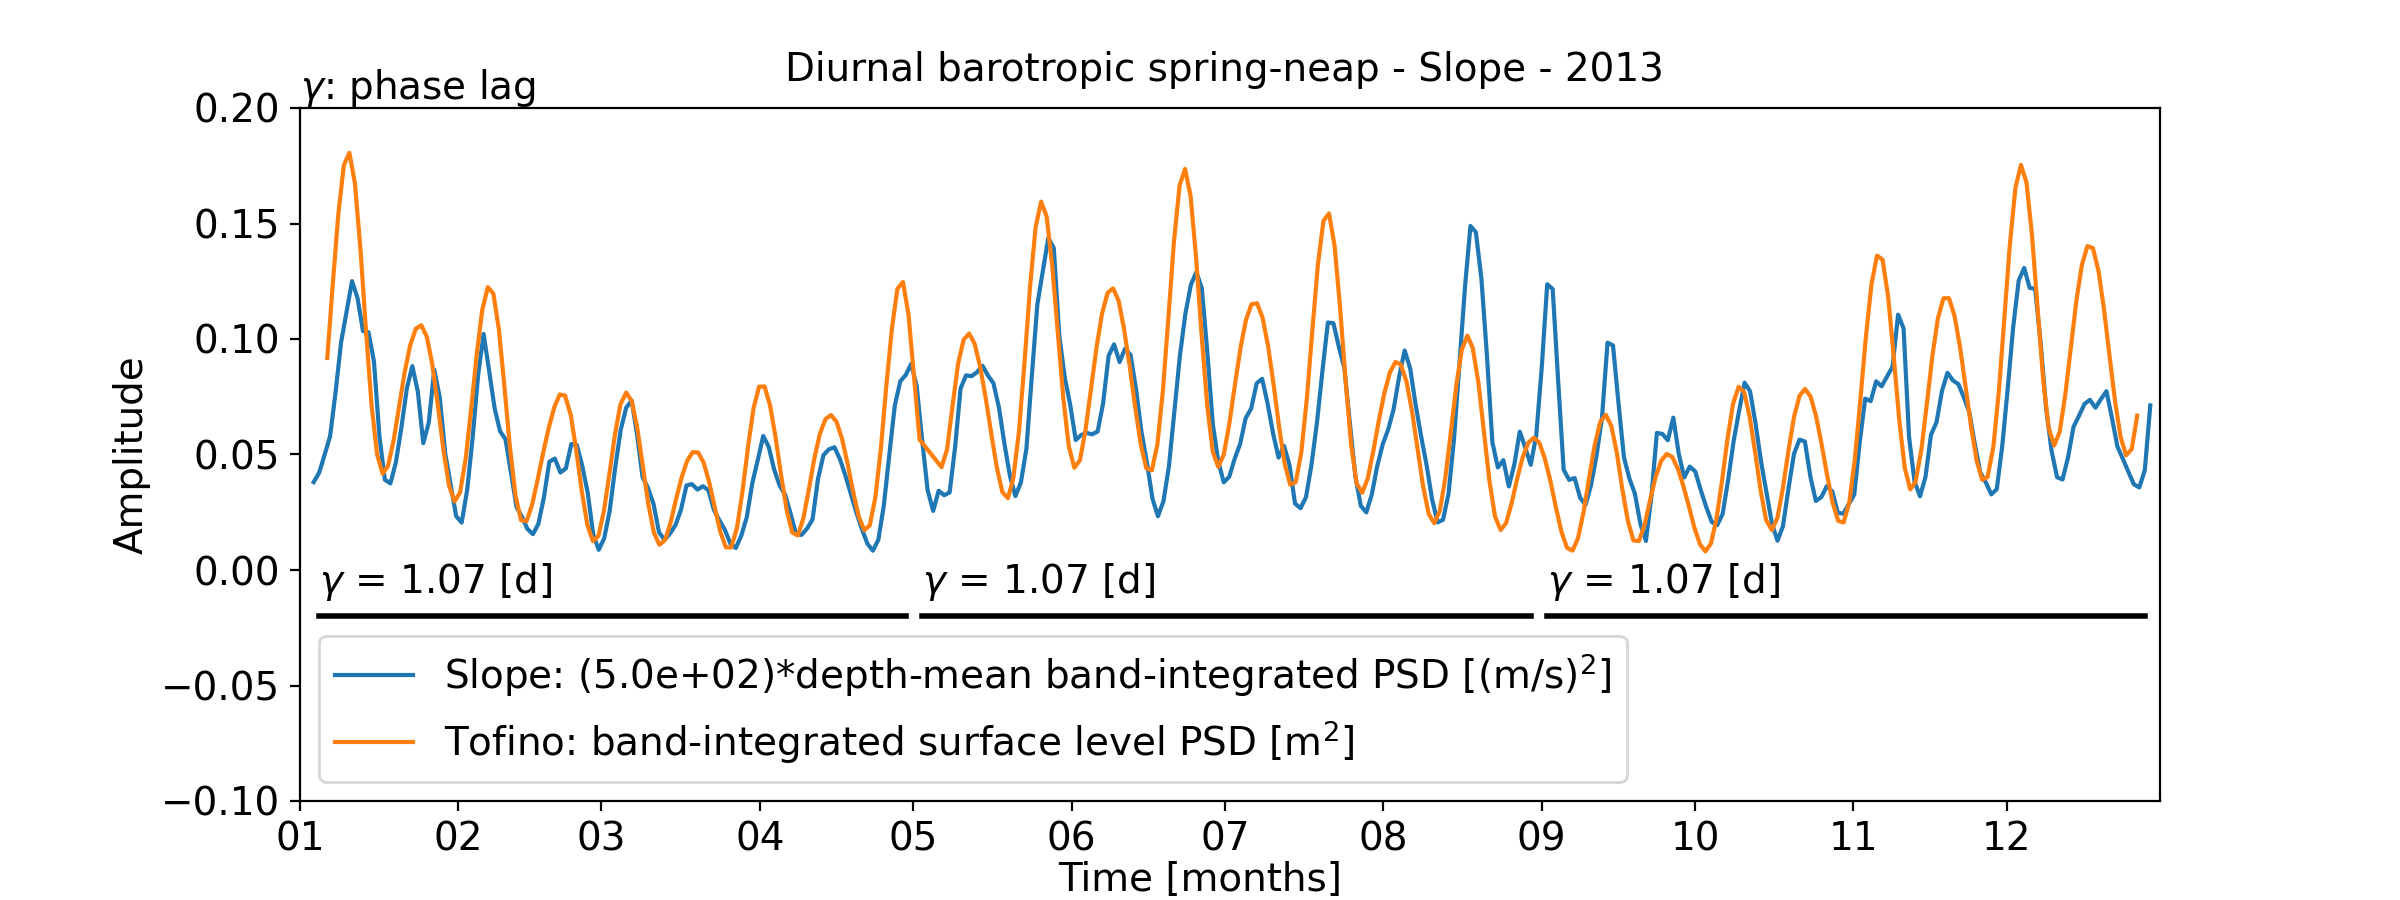

In [31]:
# check barotropic vs surface tides

fig,ax = plt.subplots(1,1,figsize=(12,4.5))

fig.text(0.51, 0.91, f'{f_name} barotropic spring-neap - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)  
fig.text(0.125,0.89,r'$\gamma$: phase lag',fontsize=14)

if t_stamp == 2013:
    if f_name == 'Diurnal' and adcp == 'Slope':
        ax.set_ylim(-0.1,0.2)
        scale = 5e2
        L1 = -0.02
        L2 = -0.01
        # plot phase lag interval
        #lag_line_x = [np.datetime64(f'{t_stamp}-05-10T06:00'),np.datetime64(f'{t_stamp}-05-11T07:40')]
        #lag_line_y = [0.08,0.08]
        #ax.plot(lag_line_x,lag_line_y,color='black')
    elif f_name == 'Diurnal' and adcp == 'Axis75':
        ax.set_ylim(-0.12,0.24)
        scale = 1e2
        L1 = -0.02
        L2 = -0.01
    elif f_name == 'Semidiurnal' and adcp == 'Slope':
        ax.set_ylim(-0.8,2.0)
        scale = 1.1e3
        L1 = -0.02
        L2 = -0.01
    elif f_name == 'Semidiurnal' and adcp == 'Axis75':
        ax.set_ylim(-0.6,1.5)
        scale = 3.5e2
        L1 = -0.05
        L2 = -0.04
elif t_stamp == 2014:
    if f_name == 'Diurnal' and adcp == 'Slope':
        ax.set_ylim(-0.1,0.22)
        scale = 6e2
        L1 = -0.02
        L2 = -0.01
    elif f_name == 'Diurnal' and adcp == 'Axis75':
        ax.set_ylim(-0.2,0.45)
        scale = 1e2
        L1 = -0.04
        L2 = -0.03
    elif f_name == 'Semidiurnal' and adcp == 'Slope':
        ax.set_ylim(-0.6,1.7)
        scale = 1.1e3
        L1 = -0.02
        L2 = -0.01
    elif f_name == 'Semidiurnal' and adcp == 'Axis75':
        ax.set_ylim(-2,4.5)
        scale = 7e2
        L1 = -0.25
        L2 = -0.2
elif t_stamp == 2017:
    if f_name == 'Diurnal' and adcp == 'Slope':
        ax.set_ylim(-0.15,0.33)
        scale = 6e2
        L1 = -0.03
        L2 = -0.02
    elif f_name == 'Diurnal' and adcp == 'Axis55':
        ax.set_ylim(-0.2,0.35)
        scale = 1.3e2
        L1 = -0.03
        L2 = -0.02
    elif f_name == 'Semidiurnal' and adcp == 'Slope':
        ax.set_ylim(-0.45,1.3)
        scale = 1.2e3
        L1 = -0.02
        L2 = -0.01
    elif f_name == 'Semidiurnal' and adcp == 'Axis55':
        ax.set_ylim(-0.8,1.8)
        scale = 3e2
        L1 = -0.15
        L2 = -0.12
elif t_stamp == 2018:
    if f_name == 'Diurnal' and adcp == 'Slope':
        ax.set_ylim(-0.1,0.23)
        scale = 6e2
        L1 = -0.02
        L2 = -0.01
    elif f_name == 'Diurnal' and adcp == 'Axis55':
        ax.set_ylim(-0.12,0.25)
        scale = 1.2e2
        L1 = -0.03
        L2 = -0.02
    elif f_name == 'Semidiurnal' and adcp == 'Slope':
        ax.set_ylim(-0.45,1.2)
        scale = 1.2e3
        L1 = -0.02
        L2 = -0.01
    elif f_name == 'Semidiurnal' and adcp == 'Axis55':
        ax.set_ylim(-1,2.4)
        scale = 5e2
        L1 = -0.16
        L2 = -0.14
        
sci = "{:.1e}".format(scale)  

for i in range(n_seg):
    if i == 0:
        bt = ax.plot(ds[i].spect_SN,U[i]*scale,label=fr'{adcp}: ({sci})*depth-mean band-integrated PSD [(m/s)$^2$]',color='tab:blue')
    elif i > 0:
        bt = ax.plot(ds[i].spect_SN,U[i]*scale,color='tab:blue')
td = ax.plot(dst.time,dst.tide,label=r'Tofino: band-integrated surface level PSD [m$^2$]',color='tab:orange')

for i in range(len(start_dates)):
    for j in range(n_seg):
        if not corrT[i][j]:
            continue
        elif len(corrT[i][j]) < 30:
            continue
        else:
            ax.plot(np.asarray(corrT[i][j][1:-1]).astype('datetime64[ns]'), np.full((len(corrT[i][j][1:-1])),L1), color='black',lw=2)
            plt.text(corrT[i][j][1].astype('datetime64[ns]'),L2,fr'$\gamma$ = %.2f [d]'%abs(phase_lag[i][j]),fontsize=14)

date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)
start = np.datetime64(f'{t_stamp}-01-01')
end = np.datetime64(f'{t_stamp}-12-31')
ax.set_xlim(start,end)
ax.tick_params(labelsize=14)
ax.set_ylabel('Amplitude',fontsize=14)

plt.legend(fontsize=14,loc='lower left')
plt.show()

plt.savefig(fname=f'./archive/tide/tide_{adcp}_{f_name}_{t_stamp}.pdf',format='pdf')

# # for making offset comparison plots
# fig.text(0.5, 0.01, 'Time [months/days]', ha='center',fontsize=14)  
# date_form = pldates.DateFormatter("%m/%d/%H")
# start = np.datetime64(f'{t_stamp}-01-20')
# end = np.datetime64(f'{t_stamp}-04-10')
# ax.set_xlim(start,end)
# ax.set_ylim(0,1)
# ax.xaxis.set_major_locator(plt.MaxNLocator(7))

#plt.show()

#plt.savefig(fname=f'./archive/tide/tide_offset_{adcp}_{f_name}_{t_stamp}.pdf',format='pdf')